# Visualization of data
----
Milan Leonard  
u6661755

----
The purpose of this notebook is to produce the images from the data

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import pennylane as qml
from pennylane import numpy
import random
import networkx as nx
from itertools import combinations, groupby
from collections import defaultdict
def strdefaultdict(): # to understand maxcutbenchmark dict
    return defaultdict(str)

In [52]:
def gnp_random_connected_graph(n, p, seed):
    """Generate a random connected graph
    n     : int, number of nodes
    p     : float in [0,1]. Probability of creating an edge
    seed  : int for initialising randomness
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)
# %%
# Leaving this as a function for multiprocessing speedup

def qaoa_costland(graph, n_layers, init_params, final_params):
    # SETUP PARAMETERS
    n_wires = len(graph.nodes)
    edges = graph.edges
    grid_size = 10
    X, Y = np.meshgrid(np.linspace(-np.pi,np.pi,grid_size),np.linspace(-np.pi,np.pi,grid_size))
    def U_B(beta):
        for wire in range(n_wires):
            qml.RX(2 * beta, wires=wire)
    def U_C(gamma):
        for edge in edges:
            wire1 = edge[0]
            wire2 = edge[1]
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(gamma, wires=wire2)
            qml.CNOT(wires=[wire1, wire2])

    dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)
    
    @qml.qnode(dev)
    def circuit(gammas, betas, edge=None, n_layers=1, n_wires=1):
        for wire in range(n_wires):
            qml.Hadamard(wires=wire)
        for i in range(n_layers):
            U_C(gammas[i])
            U_B(betas[i])
        if edges is None:
            # measurement phase
            return qml.sample(comp_basis_measurement(range(n_wires)))
        return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))
    
    init_params = 0.01 * np.random.rand(2, n_layers)
    
    def obj_wrapper(params):
        objstart = partial(objective, params, True, False)
        objend = partial(objective, params, False, True)
        return np.vectorize(objstart), np.vectorize(objend)
    
    def objective(params, start=False, end=False, X=None, Y=None):
        gammas = params[0]
        betas = params[1]
        if start:
            gammas[0] = X
            betas[0] = Y
        elif end:
            gammas[-1] = X
            betas[-1] = Y 
        neg_obj = 0
        for edge in edges:
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers, n_wires=n_wires))
        return neg_obj
    
    objstart, objend = obj_wrapper(init_params)
    meshgridfirststartparams = objstart(X, Y)
    meshgridfirstlastparams = objend(X,Y)
    objstart, objend = obj_wrapper(final_params)
    meshgridendfirstparams = objstart(X, Y)
    meshgridendlastparams = objend(X,Y)
   
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))

    return meshgridfirststartparams, meshgridfirstlastparams, meshgridendfirstparams, meshgridendlastparams

Ns = (4,   8,   12,  12)
Ps = (0.2, 0.2, 0.3, 0.1)

GRAPHS = [gnp_random_connected_graph(n,p, 42) for n,p in zip(Ns, Ps)]
GRAPH_NAMES = ["4, 0.2", "8, 0.2", "12, 0.3", "12, 0.1"]
init_params, final_params = np.array(maxcutbenchmark['adam']['4, 0.2']['2']['params'][0]), np.array(maxcutbenchmark['adam']['4, 0.2']['2']['params'][-1])
arr_map_over = [(j,str(k)) for j in GRAPH_NAMES for k in range(1,3)]
args_map = [(j,k) for j in GRAPHS for k in range(1,3)]
qaoa_costland(GRAPHS[0], 2 ,)



In [10]:
def plot_3d(X, Y, Z, xlabel, ylabel, zlabel, title, save=None):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    if save:
        plt.savefig(f"./Images/{save}.png")
    plt.show()

## Toy Model, single expectation value of simple circuit

In [15]:

with open("./datafiles/toymodel.pkl", "rb") as f:
    toymodel = pkl.load(f)

def plot_descents(save=False):
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost functions")
    plt.title("Optimizer performance")
    plt.plot(toymodel['gd'], label="Standard gradient descent")
    plt.plot(toymodel['qng'], label="Quantum Natural Gradient")
    plt.plot(toymodel['roto'], label="Rotosolve analytic minimum")
    plt.plot(toymodel['adam'], label="ADAM optimizer")
    plt.legend()
    if save:
        plt.savefig("./Images/descentcomparisons.png", dpi=500)
    plt.show()

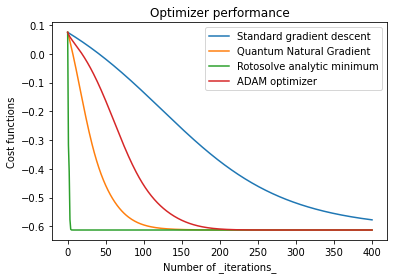

In [16]:
plot_descents()

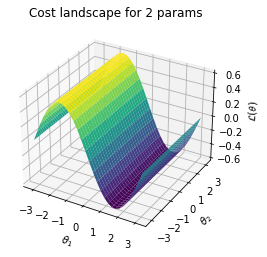

In [17]:
# Cost landscape
X, Y, Z = toymodel['meshgrid']
plot_3d(X, Y, Z, r"$\theta_1$", r"$\theta_2$", r"$\mathcal{L}(\mathbb{\theta})$", "Cost landscape for 2 params", "costlandscapetoy")

In [22]:
with open("./datafiles/output.pkl", "rb") as f:
    maxcutbenchmark = pkl.load(f)

In [33]:
maxcutbenchmark['adam']['4, 0.2']['2'].keys()

dict_keys(['losses', 'params', 'MeshGridStartFirstParams', 'MeshGridStartLastParams', 'MeshGridEndFirstParams', 'MeshGridEndLastParams'])

[[[0.002006901001060649, 0.00037118431962235635],
  [0.007646048995003466, 0.009956469500073674]],
 [[-0.09799308952270004, -0.09962879893627792],
  [-0.0923538677518364, -0.09004346025981715]],
 [[-0.09727309026987462, -0.10326037018348168],
  [-0.038416415836115624, -0.02619232294262208]],
 [[-0.08064223872551499, -0.094088296169177],
  [0.03733116564806551, 0.05430150742145519]],
 [[-0.08720104543698662, -0.10826824919507358],
  [0.1206971883438133, 0.1412015943285365]],
 [[-0.12559678718421052, -0.153527925828842],
  [0.2042403621663544, 0.2303930723877911]],
 [[-0.18221357575353891, -0.2175268785480411],
  [0.26984128647865063, 0.31638252844786857]],
 [[-0.24587990841168553, -0.2924524043969986],
  [0.2854502642383386, 0.38122825272105826]],
 [[-0.3089212028524649, -0.3742889169229404],
  [0.26166496895930136, 0.40703481082567944]],
 [[-0.36870079663517513, -0.46003070965113957],
  [0.2158765028016592, 0.39926874313947747]],
 [[-0.42485190804045136, -0.546123842556826],
  [0.15850